In [ ]:
import uuid
from IPython.display import display, HTML

def create_hide_button():
    unique_id = str(uuid.uuid4())
    display(HTML('''
        <script>
        function toggle_output(button_id) {
            var output_area = document.getElementById(button_id).parentElement.parentElement.nextElementSibling;
            var button = document.getElementById(button_id);
            if (output_area.style.display === "none") {
                output_area.style.display = "block";
                button.innerHTML = "Hide Output";
            } else {
                output_area.style.display = "none";
                button.innerHTML = "Show Output";
            }
        }
        </script>
    '''))

    button_id = f"button_{unique_id}"
    display(HTML(f'''
        <button id="{button_id}" onclick="toggle_output('{button_id}')">Show Output</button>
        <script>
            document.getElementById('{button_id}').parentElement.parentElement.nextElementSibling.style.display = 'none';
        </script>
    '''))

In [ ]:
from IPython.display import display, HTML

display(HTML('''<style>
    .jp-CodeCell .jp-InputArea {display: none;} /* Hide only code cells */
</style>'''))

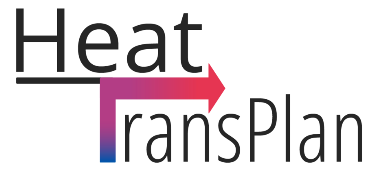


<div style="text-align: center; font-size: 50px;">
    <b>Exploratory Data Analysis</b>
</div>

## Index
- [Check the format of the variables](#format-of-the-variables)
- [Visualize the all the variables together per hour](#Visualize-the-all-the-variables-together-per-hour)
- [Process Mining: tables, case ide and activities](#Process-Mining)
- [Process Mining: process discovery schritt_l01](#Process-discovery-visual)
- [Visualize all variables per minute](#Visualize-all-variables-per-minute)
- [Visualize all variables per hour](#Visualize-all-variables-per-hour)


In [ ]:
import pandas as pd
import random
import itertools
import os
import numpy as np
from datetime import datetime, timedelta
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
#import simulation
import simpy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import chardet
import plotly.io as pio
import chardet#
import pandas as pd
from pathlib import Path
pio.renderers.default='notebook'
pd.options.mode.chained_assignment = None
from functools import reduce

In [ ]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/bronze/aixit' folder relative to the current path
files_folder = current_path.parent.parent.parent.parent / 'data' / 'raw' / 'eckes_granini'

files_folder

# Load and join the individual dfs

In [ ]:
import os
import pandas as pd

def merge_excel_files(path_folder):
    dfs_five = []
    dfs_not_five = []

    for root, dirs, files in os.walk(path_folder):
        if "Daten" in os.path.basename(root):
            print(f"\nProcessing directory: {root}")
            for file in files:
                if (file.endswith(".xlsx") or file.endswith(".xls")) and not file.startswith('~$'):
                    file_path = os.path.join(root, file)
                    try:
                        print(f"\n  Adding file: {file_path}")
                        data = pd.read_excel(file_path)
                        folder = os.path.basename(root)
                        file_no_ext = os.path.splitext(file)[0]
                        data = data.rename(columns={'Datum / Uhrzeit': 'datetime'})
                        data.columns = ['datetime' if col == 'datetime' else f"{folder}_{file_no_ext}_{col}" 
                                        for col in data.columns]
                        if 'datetime' in data.columns:
                            data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
                            # -------- Data quality checks start here --------
                            print("  Data Quality Report:")
                            dtype = data['datetime'].dtype
                            print(f"    dtype of 'datetime': {dtype}")
                            print(f"    Number of rows: {len(data)}")
                            print(f"    Earliest datetime: {data['datetime'].min()}")
                            print(f"    Latest datetime:   {data['datetime'].max()}")
                            is_datetime = pd.api.types.is_datetime64_any_dtype(data['datetime'])
                            print(f"    Column is datetime: {is_datetime}")
                            sorted_dates = data['datetime'].sort_values()
                            intervals = sorted_dates.diff().dt.total_seconds().dropna()
                            if len(intervals):
                                mean_interval = intervals.mean()
                                median_interval = intervals.median()
                                most_frequent = intervals.mode()[0]
                                print(f"    Mean interval (s): {mean_interval:.2f}")
                                print(f"    Median interval (s): {median_interval:.2f}")
                                print(f"    Most frequent interval (s): {most_frequent}")

                                if median_interval == 5:
                                    dfs_five.append(data)
                                else:
                                    dfs_not_five.append(data)
                            else:
                                print(f"    Not enough data to calculate intervals")
                                dfs_not_five.append(data)
                            # -------- Data quality checks end here --------
                        else:
                            print(f"  Skipping file {file_path} because it does not contain 'datetime' column.")
                    except Exception as e:
                        print(f"  Failed to read {file_path}: {e}")
    return dfs_five, dfs_not_five

# Usage
dfs_five, dfs_not_five = merge_excel_files(files_folder)
print(f"DataFrames with median interval 5: {len(dfs_five)}")
print(f"DataFrames with median != 5: {len(dfs_not_five)}")

In [ ]:
len(dfs_five) 

In [ ]:
len(dfs_not_five)  # Check the number of DataFrames in the list

Mache dfs haben werte pro stunden, aber die meisten jede 5 min

# Load the excel with total steam

In [ ]:
# Load the energy Excel file
df_energy_area = pd.read_excel(files_folder / 'Aufträge Energie Meldungen/Energie Istwerte PET2 KZE 08_2024.xlsx')
df_energy_area.columns = ['datetime', 'strom_PERT2_KZE', 'dampf_PET2_KZE']

df_energy_area_total = pd.read_excel(files_folder / 'Aufträge Energie Meldungen/Energie Gesamtwerte PET2 KZE 08_2024.xlsx')
df_energy_area_total.columns = ['datetime', 'strom_gesamt_PERT2_KZE', 'dampf_gesamt_PET2_KZE']

## Join the dfs per hour

In [ ]:
import pandas as pd

def group_dataframes_by_hour(dfs):
    """
    Resample each DataFrame in dfs by hour, aggregating with mean.

    Parameters:
        dfs (list of pd.DataFrame): Input DataFrames with 'datetime' column.

    Returns:
        List of DataFrames grouped by hour.
    """
    dfs_by_hour = []
    for df in dfs:
        # Convert datetime column to pandas datetime if not already
        if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
            df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
        # Remove rows with missing datetimes
        df = df.dropna(subset=['datetime'])
        # Set 'datetime' as index for resampling
        df = df.set_index('datetime')
        # Group by hour and compute mean for each hour
        df_hour = df.resample('h').mean(numeric_only=True).reset_index()
        dfs_by_hour.append(df_hour)
    return dfs_by_hour

# Usage:
dfs_by_hour = group_dataframes_by_hour(dfs_not_five)
for i, df in enumerate(dfs_by_hour):
    print(f"DF #{i} grouped by hour, shape: {df.shape}")

In [ ]:
df_to_join = dfs_by_hour 
for i, df in enumerate(df_to_join):
    n_unique = df['datetime'].nunique(dropna=True)
    n_total = len(df)
    n_na = df['datetime'].isna().sum()
    n_dupes = n_total - n_na - n_unique
    print(f"DF #{i}: {n_dupes} duplicate datetimes, {n_na} NaT/NaN, {n_unique} unique datetimes, {n_total} total rows")


In [ ]:
df_hour = reduce(lambda left, right: pd.merge(left, right, on='datetime', how='outer'), dfs_by_hour)
df_hour

## Join the dfs with 5 seconds measurements

In [ ]:
dfs_five[0]#.head(5)

In [ ]:
for df in dfs_five:
    print(df.isna().sum())

In [ ]:
df_to_join = dfs_five
for i, df in enumerate(df_to_join):
    n_unique = df['datetime'].nunique(dropna=True)
    n_total = len(df)
    n_na = df['datetime'].isna().sum()
    n_dupes = n_total - n_na - n_unique
    print(f"DF #{i}: {n_dupes} duplicate datetimes, {n_na} NaT/NaN, {n_unique} unique datetimes, {n_total} total rows")


In [ ]:
df_5_sec = reduce(lambda left, right: pd.merge(left, right, on='datetime', how='outer'), dfs_five)
df_5_sec

In [ ]:
df_5_sec.isna().sum()

In [ ]:
# Keep only rows with at least (total_columns - 6 + 1) non-NaN values
min_non_nan = df_5_sec.shape[1] - 6 + 1
df_5_sec_not_nan = df_5_sec.dropna(thresh=min_non_nan)
df_5_sec_not_nan

In [ ]:
nan_rows = df_5_sec_not_nan[df_5_sec_not_nan.isna().any(axis=1)]
nan_rows

## Final sensor join

In [ ]:
df1 = df_5_sec_not_nan.copy()
df2 = df_hour.copy()
df3 = df_energy_area.copy()
df4 = df_energy_area_total.copy()

# Append suffix to df1 columns (except 'datetime')
df1.columns = [
    col + "_5s" if col != 'datetime' else col
    for col in df1.columns
]

# Append suffix to df2 columns (except 'datetime')
df2.columns = [
    col + "_1h" if col != 'datetime' else col
    for col in df2.columns
]

# Append suffix to df2 columns (except 'datetime')
df3.columns = [
    col + "_5s" if col != 'datetime' else col
    for col in df3.columns
]

# Append suffix to df2 columns (except 'datetime')
df4.columns = [
    col + "_15m" if col != 'datetime' else col
    for col in df4.columns
]

# Merge on 'datetime'
df = df1.merge(df2, on='datetime', how='left')
df = df.merge(df3, on='datetime', how='left')
df = df.merge(df4, on='datetime', how='left')

cols_1h = [col for col in df.columns if col.endswith('_1h')]
df[cols_1h] = df[cols_1h].fillna(method='ffill')

df_sensor_joined = df

In [ ]:
df_sensor_joined.columns

In [ ]:
import re
import pandas as pd

df = df_sensor_joined.copy()

old_cols = list(df.columns)

def process_column(col):
    original = col
    
    # Skip columns that don't start with 'Daten' (these are manually named)
    if not col.startswith('Daten'):
        return col
    
    # 1. Remove value between two spaces starting with '30'
    col = re.sub(r'(?=30)[^ ]* ', ' ', col)
    # 2. Replace all spaces with underscores
    col = col.replace(' ', '_')
    # 3. Remove everything before the second "_"
    parts = col.split('_')
    if len(parts) >= 4:  # Only process if there are enough parts
        col = '_'.join(parts[3:])
    col = col.replace('__', '_')
    
    # If result is too short, return original
    if len(col) <= 3:
        return original
    return col

df.columns = [process_column(col) for col in df.columns]

df.columns = [col.replace('Daten ', '') for col in df.columns]
df.columns = [col.replace(' ', '_') for col in df.columns]

df.columns = [col.replace('Temperatur', 'temp') for col in df.columns]
df.columns = [col.replace('temperatur', 'temp') for col in df.columns]
df.columns = [col.replace('Durchfluss', 'flow') for col in df.columns]

# Table of changes (old and new column names)
col_changes = pd.DataFrame({'old_column': old_cols, 'new_column': df.columns})


df = df.loc[:, ~df.columns.duplicated()]

df_new_columns = df.copy()
df_new_columns

In [ ]:
col_changes

## Save the df

In [ ]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/bronze/aixit' folder relative to the current path
folder_to_save = current_path.parent.parent.parent.parent / 'data' / 'bronze' / 'eckes_granini'

folder_to_save

In [ ]:
df_new_columns.to_parquet(
    folder_to_save / 'df_sensor_joined.parquet',
    index=False,
    engine='pyarrow',
    compression='snappy'
)

In [ ]:
a

# Load the df

In [ ]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/bronze/aixit' folder relative to the current path
folder_to_load = current_path.parent.parent.parent.parent / 'data' / 'bronze' / 'eckes_granini'

folder_to_load

In [ ]:
df_new_columns = pd.read_parquet(folder_to_load / 'df_sensor_joined_calculations.parquet', engine='pyarrow')
df_new_columns

In [ ]:
for column in df_new_columns.columns:
    print(column)

In [ ]:
df = df_new_columns.copy()

# Exclude the datetime column
numeric_df = df.select_dtypes(include=['float', 'int'])

# Calculate descriptive statistics
stats_df = numeric_df.describe().loc[['mean', 'min', 'max']].T.reset_index()

# Rename columns
stats_df.columns = ['Column Name', 'Mean', 'Min', 'Max']

# Round values to one decimal place
stats_df[['Min', 'Mean', 'Max']] = stats_df[['Min', 'Mean', 'Max']].round(1)

stats_df = stats_df[['Column Name',  'Min', 'Mean', 'Max']]

# Export to Excel with formatted float values
stats_df.to_excel(folder_to_load / "descriptive_statistics.xlsx", index=True, float_format="%.1f")
stats_df

## EDA


In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

def visualize_data(df, datetime_col, library="plotly"):
    """
    Visualize each variable in a DataFrame with descriptive stats, histogram, and linechart.
    
    Parameters:
    - df: pandas DataFrame
    - datetime_col: column name for datetime values
    - library: visualization library to use ('plotly' or 'seaborn')
    """
    # Ensure the datetime column is in datetime format

    # Set Seaborn theme
    sns.set_theme(style="whitegrid", context="talk")

    for col in df.columns:
        if col == datetime_col:
            continue  # Skip the datetime column

        print(f"Variable: {col}")
        print(df[col].describe())
        print(f"Unique values: {df[col].nunique()}")
        print("-" * 60)

        if library == "plotly":
            # Plotly Histograms
            fig_hist = px.histogram(df, x=col, title=f"Histogram of {col}")
            fig_hist.show()

            # Plotly Line Chart
            fig_line = px.line(df, x=datetime_col, y=col, title=f"{col}")
            fig_line.show()

        elif library == "seaborn":
            # Seaborn Histogram
            plt.figure(figsize=(20, 6))
            sns.histplot(df[col], kde=True, bins=30, color="green", edgecolor="black")
            plt.title(f"Histogram of {col}", fontsize=16)
            plt.xlabel(col, fontsize=14)
            plt.ylabel("Frequency", fontsize=14)
            plt.show()

            # Seaborn Line Chart
            plt.figure(figsize=(20, 6))
            sns.lineplot(data=df, x=datetime_col, y=col, color="green", linewidth=2.5)
            plt.title(f"{col} Over Time", fontsize=16)
            plt.xlabel("Datetime", fontsize=14)
            plt.ylabel(col, fontsize=14)
            plt.xticks(rotation=45, fontsize=12)
            plt.yticks(fontsize=12)
            plt.tight_layout()
            plt.show()

        print("=" * 200) 



- [Index](#Index)

In [ ]:
df = df_new_columns.copy()

df.set_index('datetime', inplace=True)
df_resampled_1H = df.resample('h').mean(numeric_only=True).reset_index()
df_resampled_1H

# Correlation Matrix

In [ ]:
import pandas as pd
import plotly.express as px

# Assuming df_new_columns is already defined and contains your data
df = df_new_columns.copy()
df = df.drop(columns=['datetime'])

# Step 1: Calculate the correlation matrix
corr_matrix = df.corr()

# Step 2: Plot the heatmap using Plotly
fig = px.imshow(
    corr_matrix,
    text_auto=".1f",  # Round the correlation coefficients to one decimal place
    color_continuous_scale='RdBu',  # Red to blue color scale
    labels=dict(x="Variables", y="Variables", color="Correlation"),
    title="Correlation Matrix Heatmap",
    width=1000,
    height=1000
)

print('Correlation in 5 Min spans')

# Hide the color bar (legend)
fig.update_coloraxes(showscale=False)

# Step 3: Show the plot
fig.show()

- [Index](#Index)

In [ ]:
df = df_new_columns.copy()


replace_dict = {

                'temp_Produkt_Einlauf_30110TT001_1h': '(18)_temp_Produkt_Einlauf_30110TT001_1h', # Produkt Tin
                'flow_Vorlaufpumpe_30110FT301_1h': '(19)_flow_Vorlaufpumpe_30110FT301_1h', # Produkt Durchfluss

                'temp_nach_WR2_(WT2)_5s': '(14)_temp_nach_WR2_(WT2)_5s', #. Temp vor dem kuehler 
                'nach_Kuehler_(WT7)_5s': '(6)_nach_Kuehler_(WT7)_5s', # Produkt Tout

                'temp_nach_Erhitzer_(WT5)_5s': '(13)_temp_nach_Erhitzer_(WT5)_5s', # Produkt Tpasteur



                'temp_vor_Vorwärmer_(WT_2)_1h': '(20)_temp_vor_Vorwärmer_(WT_2)_1h', # Temp nach WT3
                'temp_nach_WR2,_vor_Druckerhoehungspumpe_(WT4)_5s': '(12)_temp_nach_WR2,_vor_Druckerhoehungspumpe_(WT4)_5s', # Vor dem Erhitzer


                }

density_juice = 1.05  # kg/L
cp_juice = 3.8  # kJ/kgK

# df = df[relevant_sensors].copy()
df = df.rename(columns=replace_dict)

df['(19)_mass_Vorlaufpumpe_30110FT301_1h'] = df['(19)_flow_Vorlaufpumpe_30110FT301_1h'] * density_juice # Produkt massenstrom


df['(30)_aufheizen_saft'] = df['(19)_mass_Vorlaufpumpe_30110FT301_1h'] * cp_juice * (df['(13)_temp_nach_Erhitzer_(WT5)_5s'] - df['(18)_temp_Produkt_Einlauf_30110TT001_1h']) / 3600  # kW -> Qheating
df['(31)_kuehlen_saft'] = df['(19)_mass_Vorlaufpumpe_30110FT301_1h'] * cp_juice * (df['(13)_temp_nach_Erhitzer_(WT5)_5s'] -df['(6)_nach_Kuehler_(WT7)_5s']) / 3600  # kW -> Qcooling


df_calcualted = df.copy()


# Save the joined calculated

In [ ]:
# # Define the path to the current file's location
# current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# # Navigate to the 'data/bronze/aixit' folder relative to the current path
# folder_to_save = current_path.parent.parent.parent.parent / 'data' / 'bronze' / 'eckes_granini'

# folder_to_save


# # Save to Parquet
# df_calcualted.to_parquet(
#     folder_to_save / 'df_sensor_joined_calculations.parquet',
#     index=False,
#     engine='pyarrow',
#     compression='snappy'
# )

# # Save to CSV
# df_calcualted.to_csv(folder_to_save / 'df_sensor_joined_calculations.csv', index=False)

# relevant_sensors = ['(18)_temp_Produkt_Einlauf_30110TT001_1h', 
#                     '(19)_flow_Vorlaufpumpe_30110FT301_1h', 
#                     '(14)_temp_nach_WR2_(WT2)_5s', 
#                     '(6)_nach_Kuehler_(WT7)_5s', 
#                     '(12)_temp_nach_WR2,_vor_Druckerhoehungspumpe_(WT4)_5s', 
#                     '(13)_temp_nach_Erhitzer_(WT5)_5s',
#                     '(19)_mass_Vorlaufpumpe_30110FT301_1h',
#                     '(30)_aufheizen_saft',
#                     '(31)_kuehlen_saft',
#                     'flow_Dampf_WT3a/5a)_5s'
#                     ]

# Visualize the all the variables together for one day

In [ ]:
import pandas as pd
import plotly.express as px

df = df_calcualted.copy()
df['datetime'] = pd.to_datetime(df['datetime'])

date = '2024-08-01'  # Example date to filter

# Filter for one day, for example 2024-08-01
date_mask = df['datetime'].dt.date == pd.to_datetime(date).date()
df = df[date_mask]

# Melt to long format: one row per datetime/variable/value
df_long = df.melt(id_vars='datetime', var_name='variable', value_name='value')

# Plot
fig = px.line(
    df_long,
    x='datetime',
    y='value',
    color='variable',
    title=f'Interactive Visualization of Variables for {date}'
)
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Value',
    legend_title='Variables',
    hovermode='x unified',
)
fig.show()

- [Index](#Index)

 # Visualize the all the variables together scaling them from 0 to 1

 #### It is posible to select individual variables on the legend

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

df = df_new_columns.copy()
df['datetime'] = pd.to_datetime(df['datetime'])
date = '2024-08-01'  # Example date to filter

# Filter for the desired date
date_mask = df['datetime'].dt.date == pd.to_datetime(date).date()
df = df[date_mask]

# Exclude 'datetime' column for scaling
columns_to_scale = df.columns.drop('datetime')

# Scale the variables to the range [0, 1]
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Melt to long format for Plotly
df_long = df.melt(id_vars='datetime', var_name='variable', value_name='value')

# Plot
fig = px.line(
    df_long,
    x='datetime',
    y='value',
    color='variable',
    title=f'Interactive Visualization of Scaled Variables for {date}'
)
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Scaled Value',
    legend_title='Variables',
    hovermode='x unified',
)
fig.show()

In [ ]:
df = df_new_columns.copy()
folder_to_load  # Replace 'files_fo' with 'folder_to_load' or define the variable if needed

# Visualize the all the variables together for all days per hour

In [ ]:
import pandas as pd
import plotly.express as px

df = df_resampled_1H.copy()
df['datetime'] = pd.to_datetime(df['datetime'])

# Melt to long format: one row per datetime/variable/value
df_long = df.melt(id_vars='datetime', var_name='variable', value_name='value')

# Plot
fig = px.line(
    df_long,
    x='datetime',
    y='value',
    color='variable',
    title=f'Interactive Visualization of Variables for {date}'
)
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Value',
    legend_title='Variables',
    hovermode='x unified',
)
fig.show()

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

df = df_resampled_1H.copy()
df['datetime'] = pd.to_datetime(df['datetime'])

# Exclude 'datetime' column for scaling
columns_to_scale = df.columns.drop('datetime')

# Scale the variables to the range [0, 1]
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Melt to long format for Plotly
df_long = df.melt(id_vars='datetime', var_name='variable', value_name='value')

# Plot
fig = px.line(
    df_long,
    x='datetime',
    y='value',
    color='variable',
    title=f'Interactive Visualization of Scaled Variables for {date}'
)
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Scaled Value',
    legend_title='Variables',
    hovermode='x unified',
)
fig.show()

# Select relevant sensors

In [ ]:
df_resampled_1H

## Show unique values per column

In [ ]:
df = df_raw.copy()
df = df.dropna(subset=["schritt_l01_"])


print('schritt_l01_ :', df['schritt_l01_'].unique())
print('schritt_l02_ :',df['schritt_l02_'].unique())
print('mat_id_m01_ :' ,df['mat_id_m01_'].unique())
print('mat_id_m02_ :',df['mat_id_m02_'].unique())
print('mat_id_m03_ :',df['mat_id_m03_'].unique())

# Process Mining

Show rows of the dataframe per hour to see combinations of Schritt and mat 

In [ ]:
create_hide_button()

pd.set_option('display.max_rows', None)     # Show all rows

df = df_resampled_1H[['datetime','schritt_l01_', 'schritt_l02_', 'mat_id_m01_', 'mat_id_m02_', 'mat_id_m03_']]#.drop_duplicates()

df['unique_columns'] = df[['schritt_l01_', 'schritt_l02_', 'mat_id_m01_', 'mat_id_m02_', 'mat_id_m03_']].apply(lambda x: '_'.join(x.astype(str)), axis=1)

df = df#.drop_duplicates(subset=['unique_columns'], keep='first')

df

- Create a case id for Schritt_l01. Case_ide = mat_id_m01 + first appereance of that material in the process
- Combine case ide with process steps (machine status) to filter and have only the first time that happenen

It is not clear how the processes are connected together. Is Mat01 going to Schritt L01?

In [ ]:
create_hide_button()

pd.set_option('display.max_rows', None)  

df = df_resampled_1H[['datetime', 'schritt_l01_', 'schritt_l02_', 'mat_id_m01_', 'mat_id_m02_', 'mat_id_m03_']]

column = 'schritt_l01_'

#df = df[df[column]>0]

df[column] = column + df[column].astype(str)

# Detect changes in 'mat_id_m01_' and mark them with 1
df['change'] = (df['mat_id_m01_'] != df['mat_id_m01_'].shift()).astype(int)

# Create a cumulative sum of the changes
df['change_cumsum'] = df['change'].cumsum()

# Combine 'mat_id_m01_' with the cumulative count to create 'case_id'
df['case_id'] = df['mat_id_m01_'].astype(str) + '_' + df['change_cumsum'].astype(str)

# Combine 'mat_id_m01_' with the cumulative count to create 'case_id'
df['case_id_activity'] = df['case_id'] + '_' + df['schritt_l01_']

df = df.drop_duplicates(subset=['case_id_activity'])

#df = df[df['mat_id_m01_']>0]

store_df = df.copy()
store_df 

# Process discovery visual
##### Show a process graph for schritt_l01

In [ ]:
import pm4py
import pandas as pd

#### for process in store_df['process_name'].unique():
#### Filter the dataframe for the current process
process_df = store_df#[store_df['process_name'] == process]

# Format the dataframe for PM4Py
event_log = pm4py.format_dataframe(process_df, case_id='case_id', activity_key='schritt_l01_', timestamp_key='datetime')

# Discover the Directly-Follow Graph (DFG)
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)

# View the DFG
pm4py.view_dfg(dfg, start_activities, end_activities)

- [Index](#Index)

 # Visualize all variables per minute

In [ ]:
create_hide_button()

pd.set_option('display.max_rows', 10)
# Display the resampled DataFrame
display(df_resampled_5_min)
visualize_data(df_resampled_5_min, datetime_col="datetime", library="seaborn")

- [Index](#Index)

 # Visualize all variables per hour

In [ ]:
create_hide_button()
#### The variables are resampled per hour
pd.set_option('display.max_rows', 10)

# Display the resampled DataFrame
display(df_resampled_1H)
visualize_data(df_resampled_1H, datetime_col="datetime", library="plotly")

- [Index](#Index)